# Text Aligning Pipeline

## Задача

Хотим выровнить два качественно переведенных человеком текста. В данном случае на китайском и русском языках.

## План

**Сделано**

- Выравнивать будем через proxy-текст.
- Proxy-текст получим машинным переводом
  - Bing, Amazon дают 2M символов на free-tier плане.
  - Яндекс переводит документы в pdf и docx.
  - Google'ом удобно переводить небольшие тексты в браузере.
- Для машинно-переведенного и правильного текстов считаем семантическую близость.
  - Например, косинусную близость для вектров из DeepPavlov/rubert-base-cased-sentence. 
- Используем различного рода оптимизации.
  - Предобработатываем тексты.
  - Лемматизируем.
  - Ищем пары в окне.  
  - Делаем ngram'ы для предложений (Предложению на русском может соответствовать несколько предложений на китайском).
- Находим пары машинный-правильный текст с каким-то порогом.
  - Коэффициент наклона при поиске по матрице, так как количество строк значительно различается.
  - Разбить на батчи, чтобы хватило памяти.
- Получаем пары из двух первоначальных текстов.

**Улучшения**

- Полученые кандидаты надо фильтровать.
  - Оригинал и proxy носитель русского может оценить самостоятельно.
  - Помечать несоответствия, отфильтровывать их.
  - UI.
- Делать в несколько этапов с различными параметрами (ngram, window, max_sent_length, diff).
  - Найденные пары исключать из последующих этапов. 

## Разбиваем тексты на предложения

In [1]:
import pymorphy2
import re
import torch
import seaborn as sns
import numpy as np
import razdel

from scipy import spatial
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelWithLMHead

In [2]:
text_ru = r"D:\ml\c\raw\ru\chekhov_futlar_raw_ru.txt"
text_zh = r"D:\ml\c\raw\zh\chekhov_futlar_raw_zh.txt"

text_ru_splitted = r"D:\ml\c\splitted\chekhov_futlar_splitted_ru.txt"
text_zh_splitted = r"D:\ml\c\splitted\chekhov_futlar_splitted_zh.txt"

text_ru_proxy = r"D:\ml\c\proxy\chekhov_futlar_splitted_zh.ru.txt"

### Russian

In [54]:
pattern_ru_orig = re.compile(r'[a-zA-Z\(\)\[\]\/\<\>•\'\n]+')
double_spaces = re.compile(r'[\s]+')
double_commas = re.compile(r'[,]+')
double_dash = re.compile(r'[-—]+')

with open(text_ru, mode='r', encoding='utf-8') as input_ru, open(text_ru_splitted, mode='w', encoding='utf-8') as out_ru:
    ru = ' '.join(input_ru.readlines())
    ru = re.sub(pattern_ru_orig, '', ru)
    ru = re.sub(double_spaces, ' ', ru)
    ru = re.sub(double_commas, ',', ru)
    ru = re.sub(double_dash, '—', ru)
    
    sent_ru = list(x.text for x in razdel.sentenize(ru))
    
    count = 1
    for x in sent_ru:
        if count < len(sent_ru)-1:
            out_ru.write(x.strip() + "\n")
        else:
            out_ru.write(x.strip())
        count += 1
            
print(len(sent_ru))

241


In [4]:
sent_ru[:20]

['ЧЕЛОВЕК В ФУТЛЯРЕ На самом краю села Мироносицкого, в сарае старосты Прокофия, расположились на ночлег запоздавшие охотники.',
 'Их было только двое: ветеринарный врач Иван Иваныч и учитель гимназии Буркин.',
 'У Ивана Иваныча была довольно странная, двойная фамилия — Чимша—Гималайский, которая совсем не шла ему, и его во всей губернии звали просто по имени и отчеству; он жил около города на конском заводе и приехал теперь на охоту, чтобы подышать чистым воздухом.',
 'Учитель же гимназии Буркин каждое лето гостил у графов П. и в этой местности давно уже был своим человеком.',
 'Не спали.',
 'Иван Иваныч, высокий худощавый старик с длинными усами, сидел снаружи у входа и курил трубку; его освещала луна.',
 'Буркин лежал внутри на сене, и его не было видно в потемках.',
 'Рассказывали разные истории.',
 'Между прочим, говорили о том, что жена старосты, Мавра, женщина здоровая и неглупая, во всю свою жизнь нигде не была дальше своего родного села, никогда не видела ни города, ни железно

### Chinese

In [58]:
pattern_zh = re.compile(r'[」「“”„‟\x1a⓪①②③④⑤⑥⑦⑧⑨⑩⑴⑵⑶⑷⑸⑹⑺⑻⑼⑽*a-zA-Zа-яА-Я\(\)\[\]\s\n\/\-\:•＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》【】〔〕〖〗〘〙〜〟〰〾〿–—‘’‛‧﹏〉]+')
pat_comma = re.compile(r'[\.]+')

def split_zh(paragraph):
    for sent in re.findall(u'[^!?。！？\.\!\?]+[!?。！？\.\!\?]?', paragraph, flags=re.U):
        yield sent

with open(text_zh, mode='r', encoding='utf-8') as input_zh, open(text_zh_splitted, mode='w', encoding='utf-8') as out_zh:
    zh = ''.join(input_zh.readlines())    
    zh = re.sub(pat_comma, '。', zh)
                       
    sent_zh = list(re.sub(pattern_zh,'',x.strip()) for x in split_zh(zh))

    count = 1
    for x in sent_zh:
        if count < len(sent_zh)-1:
            out_zh.write(x.strip() + "\n")
        else:
            out_zh.write(x.strip())
        count += 1
        
print(len(sent_zh))

311


In [59]:
sent_zh[:20]

['误了时辰的猎人们在米罗诺西茨科耶村边上村长普罗科菲的堆房里住下来过夜了。',
 '他们一共只有两个人兽医伊万伊万内奇和中学教师布尔金。',
 '伊万。',
 '伊万内奇姓一个相当古怪的双姓奇姆沙吉马莱斯基，这个姓跟他一点也不相称，全省的人就简单地叫他的本名和父名伊万伊万内奇。',
 '他住在城郊一个养马场上，这回出来打猎是为了透一透新鲜空气。',
 '然而中学教师布尔金每年夏天都在伯爵家里做客，对这个地区早已熟透了。',
 '他们没睡觉。',
 '伊万伊万内奇是一个又高又瘦的老人，留着挺长的唇髭，这时候坐在门口，脸朝外，吸着烟斗。',
 '月亮照在他身上。',
 '布尔金躺在房里的干草上，在黑暗里谁也看不见他。',
 '他们讲起各种各样的事。',
 '顺便他们还谈到村长的妻子玛芙拉。',
 '她是一个健康而不愚蠢的女人，可是她一辈子从没走出过她家乡的村子，从没见过城市或者铁路，近十年来一直守着炉灶，只有夜间才到街上去走一走。',
 '这有什么可奇怪的！',
 '布尔金说，那种性情孤僻像寄生蟹或者蜗牛那样极力缩进自己的硬壳里去的人，这世界上有不少呢。',
 '也许这是隔代遗传的现象，重又退回从前人类祖先还不是群居的动物而是孤零零地住在各自洞穴里的时代的现象，不过，也许这只不过是人类性格的一种类型吧，谁知道呢？',
 '我不是博物学家，探讨这类问题不是我的事。',
 '我只想说像玛芙拉那样的人并不是稀有的现象。',
 '是啊，不必往远里去找，就拿一个姓别里科夫的人来说好了，他是我的同事，希腊语教师，大约两个月前在我们城里去世了。',
 '当然，您一定听说过他。']

## Proxy-перевод

Proxy-переводом назовем машинный перевод одного из текстов на язык второго и будем использовать его для подсчета семантической близости. 

In [138]:
#text_ru_proxy = r"D:\ml\c\proxy\chekhov_futlar_splitted_zh.ru.txt"

## Переводим предложения в векторы

Тут есть варианты, выбрать embedding'и по вкусу (word2vec, FastText, ELMo, Rubert). Возьмем Rubert sentence от DeepPavlov через huggingface.

In [5]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModelWithLMHead.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

def get_sent_vec(text):
    tokenized_text = tokenizer.encode(text, add_special_tokens=True)
    #indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor(tokenized_text).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        return model(tokens_tensor)[0]

### Russian

Мы переводим в векторы два текста **на русском**.

In [60]:
#тексты разбиты по строкам.

first_numbers = re.compile(r'^[0-9,\.]+')
last_punct = re.compile(r'[,\.]+$')
multiple_spaces = re.compile(r'\s+')
pattern_ru = re.compile(r'[a-zA-Z\.\(\)\[\]\/\-\:!?\<\>;•\"\'«»——,]+')

#лемматизация
morph = pymorphy2.MorphAnalyzer()

def get_file_vectors(path_ru):
    ru_vectors = []
    with open(path_ru, mode="r", encoding="utf-8") as input_ru:
        for line_ru in input_ru.readlines():
            line_ru = re.sub(pattern_ru, '', line_ru).strip()
            line_ru = re.sub(last_punct, '', line_ru).strip()
            line_ru = re.sub(first_numbers, '', line_ru).strip()
            line_ru = re.sub(multiple_spaces, ' ', line_ru).strip()
            line_ru = line_ru.lower()

            line_ru = ' '.join(list(map(lambda x: morph.parse(x)[0].normal_form, line_ru.split())))
            #print(line_ru)
            ru_vectors.append(get_sent_vec(line_ru))
    return ru_vectors

    #print("-------------------------------------")

In [61]:
vectors_ru1 = get_file_vectors(text_ru_proxy)
vectors_ru2 = get_file_vectors(text_ru_splitted)

## Считаем близость

In [72]:
#добавим окно, — правильные строки должны быть не очень далеко друг от друга.

def get_sim_matrix(ru_vec, ru_vec2):
    sim_matrix=np.zeros((len(ru_vec), len(ru_vec2)))
    k = len(ru_vec)/len(ru_vec2)
    for i in range(len(ru_vec)):
        for j in range(len(ru_vec2)):
            window = 10
            if (j*k > i-window) & (j*k < i+window):
                sim = 1 - spatial.distance.cosine(ru_vec[i][0,-1,:], ru_vec2[j][0,-1,:])
                sim_matrix[i,j] = sim

    return sim_matrix

In [73]:
sim_matrix = get_sim_matrix(vectors_ru1, vectors_ru2)

## Визуализация

pairs found: 89


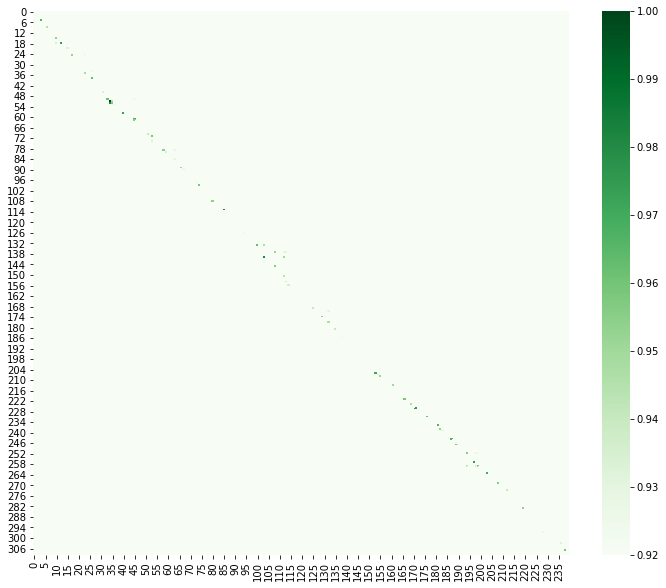

In [99]:
threshold = 0.92

plt.figure(figsize=(12,10))
sns.heatmap(sim_matrix,cmap="Greens", vmin=threshold)

count = 0
for i in range(sim_matrix.shape[0]):
    for j in range(sim_matrix.shape[1]):
        if sim_matrix[i,j] >= threshold:
            count += 1
#             print(i, j, sim_matrix[i,j])
        
print("pairs found:", count)

## Восстановим пары

In [100]:
def get_pairs(ru_lines, ru_lines2, zh_lines, sim_matrix, threshold):
    ru = []
    ru2 = []
    zh = []
    for i in range(sim_matrix.shape[0]):
        for j in range(sim_matrix.shape[1]):
            if sim_matrix[i,j] >= threshold:
                ru.append(ru_lines[j])
                ru2.append(ru_lines2[i])
                zh.append(zh_lines[i])
    return ru,ru2,zh

In [101]:
with open(text_ru_splitted, mode="r", encoding="utf-8") as input_ru, \
     open(text_zh_splitted, mode="r", encoding="utf-8") as input_zh, \
     open(text_ru_proxy, mode="r", encoding="utf-8") as input_proxy:
    lines_ru = input_ru.readlines()
    lines_zh = input_zh.readlines()
    lines_ru_proxy = input_proxy.readlines()    

res_ru, res_ru_proxy, res_zh = get_pairs(lines_ru, lines_ru_proxy, lines_zh, sim_matrix, threshold)

print(len(res_ru))

89


In [102]:
for x,y,z in zip(res_ru, res_ru_proxy, res_zh):
#     print("[Original text]")
    print(x)
#     print("[Machine translated]")
#     print(y)
#     print("[Target text]")
    print(z)
    print("-----------------------------")

Учитель же гимназии Буркин каждое лето гостил у графов П. и в этой местности давно уже был своим человеком.

然而中学教师布尔金每年夏天都在伯爵家里做客，对这个地区早已熟透了。

-----------------------------
Буркин лежал внутри на сене, и его не было видно в потемках.

布尔金躺在房里的干草上，在黑暗里谁也看不见他。

-----------------------------
Быть может, тут явление атавизма, возвращение к тому времени, когда предок человека не был еще общественным животным и жил одиноко в своей берлоге, а может быть, это просто одна из разновидностей человеческого характера,— кто знает?

也许这是隔代遗传的现象，重又退回从前人类祖先还不是群居的动物而是孤零零地住在各自洞穴里的时代的现象，不过，也许这只不过是人类性格的一种类型吧，谁知道呢？

-----------------------------
Быть может, тут явление атавизма, возвращение к тому времени, когда предок человека не был еще общественным животным и жил одиноко в своей берлоге, а может быть, это просто одна из разновидностей человеческого характера,— кто знает?

是啊，不必往远里去找，就拿一个姓别里科夫的人来说好了，他是我的同事，希腊语教师，大约两个月前在我们城里去世了。

-----------------------------
Да вот, недалеко искать, месяца два назад умер

# TAP!

Соберем все в один вызов.

In [73]:
import os

pattern_ru_orig = re.compile(r'[a-zA-Z\(\)\[\]\/\<\>•\'\n]+')
double_spaces = re.compile(r'[\s]+')
double_commas = re.compile(r'[,]+')
double_dash = re.compile(r'[-—]+')
pattern_zh = re.compile(r'[」「“”„‟\x1a⓪①②③④⑤⑥⑦⑧⑨⑩⑴⑵⑶⑷⑸⑹⑺⑻⑼⑽*a-zA-Zа-яА-Я\(\)\[\]\s\n\/\-\:•＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》【】〔〕〖〗〘〙〜〟〰〾〿–—‘’‛‧﹏〉]+')
pat_comma = re.compile(r'[\.]+')
first_numbers = re.compile(r'^[0-9,\.]+')
last_punct = re.compile(r'[,\.]+$')
multiple_spaces = re.compile(r'\s+')
pattern_ru = re.compile(r'[a-zA-Z\.\(\)\[\]\/\-\:!?\<\>;•\"\'«»——,]+')
pattern_ru_letters_only = re.compile(r'[^а-яА-Я\s]+')

def split_zh(paragraph):
    for sent in re.findall(u'[^!?。！？\.\!\?]+[!?。！？\.\!\?]?', paragraph, flags=re.U):
        yield sent
            
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModelWithLMHead.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

def get_sent_vec(text):
    tokenized_text = tokenizer.encode(text, add_special_tokens=True)
    #indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    tokens_tensor = torch.tensor(tokenized_text).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        return model(tokens_tensor)[0]

#лемматизация
morph = pymorphy2.MorphAnalyzer()

def get_file_vectors(path_ru):
    ru_vectors = []
    with open(path_ru, mode="r", encoding="utf-8") as input_ru:
        for line_ru in input_ru.readlines():
            line_ru = re.sub(pattern_ru, '', line_ru).strip()
            line_ru = re.sub(last_punct, '', line_ru).strip()
            line_ru = re.sub(first_numbers, '', line_ru).strip()
            line_ru = re.sub(multiple_spaces, ' ', line_ru).strip()
            line_ru = line_ru.lower()

            line_ru = ' '.join(list(map(lambda x: morph.parse(x)[0].normal_form, line_ru.split())))
            #print(line_ru)
            ru_vectors.append(get_sent_vec(line_ru))
    return ru_vectors

def get_line_vectors(lines):
    ru_vectors = []
    for line_ru in lines:
        line_ru = re.sub(pattern_ru, '', line_ru).strip()
        line_ru = re.sub(last_punct, '', line_ru).strip()
        line_ru = re.sub(first_numbers, '', line_ru).strip()
        line_ru = re.sub(multiple_spaces, ' ', line_ru).strip()
        line_ru = line_ru.lower()

        line_ru = ' '.join(list(map(lambda x: morph.parse(x)[0].normal_form, line_ru.split())))
        #print(line_ru)
        ru_vectors.append(get_sent_vec(line_ru))
    return ru_vectors

In [97]:
def get_pairs(ru_lines, zh_lines, ru_proxy_lines, sim_matrix, threshold):
    ru = []
    zh = []
    ru_proxy = []
    sims = []
    for i in range(sim_matrix.shape[0]):
        for j in range(sim_matrix.shape[1]):
            if sim_matrix[i,j] >= threshold:
                ru.append(ru_lines[j])
                zh.append(zh_lines[i])
                ru_proxy.append(ru_proxy_lines[i])
                sims.append(sim_matrix[i,j])
                
    return ru,zh,ru_proxy,sims

def get_sim_matrix(ru_vec, ru_vec2, window=10):
    sim_matrix=np.zeros((len(ru_vec), len(ru_vec2)))
    k = len(ru_vec)/len(ru_vec2)
    for i in range(len(ru_vec)):
        for j in range(len(ru_vec2)):
            if (j*k > i-window) & (j*k < i+window):
                sim = 1 - spatial.distance.cosine(ru_vec[i][0,-1,:], ru_vec2[j][0,-1,:])
                sim_matrix[i,j] = sim

    return sim_matrix  

def align_texts(file_ru, file_zh, threshold, batch_size=50, window=10, n_gram=1, n_gram_sent_max_words=20, l_diff=0.8, debug=False, vectors_ru1=None, vectors_ru2=None):
    
    splitted_ru = os.path.join("D:\ml\c\splitted", os.path.basename(file_ru))
    splitted_zh = os.path.join("D:\ml\c\splitted", os.path.basename(file_zh))
    proxy_ru = os.path.join("D:\ml\c\proxy", os.path.basename(file_ru))    
    ngramed_splitted_zh = os.path.join("D:\ml\c\gramed", os.path.basename(file_zh))
    ngramed_proxy_ru = os.path.join("D:\ml\c\gramed", os.path.basename(file_ru))    
    output_ru = os.path.join("D:\ml\c\done", os.path.basename(file_ru))
    output_zh = os.path.join("D:\ml\c\done", os.path.basename(file_zh))
    
    print("Splitting ru.")
    with open(file_ru, mode='r', encoding='utf-8') as input_ru, open(splitted_ru, mode='w', encoding='utf-8') as out_ru:
        ru = ' '.join(input_ru.readlines())
        ru = re.sub(pattern_ru_orig, '', ru)
        ru = re.sub(double_spaces, ' ', ru)
        ru = re.sub(double_commas, ',', ru)
        ru = re.sub(double_dash, '—', ru)

        sent_ru = list(x.text for x in razdel.sentenize(ru))

        count = 1
        for x in sent_ru:
            if count < len(sent_ru)-1:
                out_ru.write(x.strip() + "\n")
            else:
                out_ru.write(x.strip())
            count += 1
            
    print("Russian text lines:", len(sent_ru), "\n")
    
    print("Splitting zh.")
    with open(file_zh, mode='r', encoding='utf-8') as input_zh, open(splitted_zh, mode='w', encoding='utf-8') as out_zh:
        zh = ''.join(input_zh.readlines())    
        zh = re.sub(pat_comma, '。', zh)

        sent_zh = list(re.sub(pattern_zh,'',x.strip()) for x in split_zh(zh))

        count = 1
        for x in sent_zh:
            if count < len(sent_zh)-1:
                out_zh.write(x.strip() + "\n")
            else:
                out_zh.write(x.strip())
            count += 1

    print("Chinese text lines:", len(sent_zh), "\n")    
    
    #check if proxy file exists
    if not(os.path.isfile(proxy_ru)):
        raise Exception("Proxy file not found:", proxy_ru)
    
    print("Proxy file is found:")
    print(proxy_ru + "\n")
    
    print("Creating ngrammed by sentence text files...")
    #ngramming
#     max_sent_words = 20 #don't process very long sentences.
    count_ngramed = 0
    with open(splitted_zh, mode="r", encoding="utf-8") as input_zh, \
         open(proxy_ru, mode="r", encoding="utf-8") as input_proxy, \
         open(ngramed_splitted_zh, mode='w', encoding='utf-8') as ngram_zh, \
         open(ngramed_proxy_ru, mode='w', encoding='utf-8') as ngram_ru:
        lines_zh = input_zh.readlines()
        lines_ru_proxy = input_proxy.readlines()
        file_len = len(lines_ru_proxy)
        
        for i in range(file_len):
            #process sentence
            #always write original sentence
            ngram_ru.write(lines_ru_proxy[i].strip() + "\n")
            ngram_zh.write(lines_zh[i].strip() + "\n")
            count_ngramed += 1
            #add ngamed sentences
            for k in range(1, n_gram):
                #write if every sentence is longer than max_sent_words
                to_write = True
                line_ru = ""
                line_zh = ""
                for j in range(k+1):
                    if (len(re.sub(pattern_ru_letters_only,'',lines_ru_proxy[min(i+j, file_len-1)]).split())>n_gram_sent_max_words):
                        to_write = False
                    line_ru += lines_ru_proxy[min(i+j, file_len-1)].strip()
                    line_ru += " "
                    
                    line_zh += lines_zh[min(i+j, file_len-1)].strip()
                    
                    #ngram_ru.write(lines_ru_proxy[min(i+j, file_len-1)].strip() + " ")
                    #ngram_zh.write(lines_zh[min(i+j, file_len-1)].strip() + " ")
                if to_write:
                    ngram_ru.write(line_ru + "\n")
                    ngram_zh.write(line_zh + "\n")
                    count_ngramed += 1
                    #ngram_zh.write("\n")
    
    
    
    print("Ngrammed Chinese text lines:", count_ngramed, "\n")   
#     raise Exception("debug")
    
    #batching    
    with open(splitted_ru, mode="r", encoding="utf-8") as input_ru, \
         open(ngramed_splitted_zh, mode="r", encoding="utf-8") as input_zh, \
         open(ngramed_proxy_ru, mode="r", encoding="utf-8") as input_proxy:
        lines_ru = input_ru.readlines()
        lines_zh = input_zh.readlines()
        lines_ru_proxy = input_proxy.readlines()    
    
    batch_number = 0
    total_pairs = 0
    with open(output_ru, mode='w', encoding='utf-8') as out_ru, open(output_zh, mode='w', encoding='utf-8') as out_zh:
        for lines_ru_batch, lines_ru_proxy_batch, lines_zh_batch in get_batch(lines_ru, lines_ru_proxy, lines_zh, batch_size):
            batch_number += 1

            #print(lines_ru_batch)
            
            print("--------------------------------------")
            print("batch:", batch_number, "[", (batch_number-1) * batch_size, "-", batch_number * batch_size, "]", "Calculating vectors...")
            vectors_ru1 = get_line_vectors(lines_ru_proxy_batch)
            vectors_ru2 = get_line_vectors(lines_ru_batch)
            
#             if vectors_ru1 is None:
#                 vectors_ru1 = get_line_vectors(lines_ru_proxy_batch)
#             if vectors_ru2 is None:
#                 vectors_ru2 = get_line_vectors(lines_ru_batch)

            print("Calculating similarity matrix...")
            sim_matrix = get_sim_matrix(vectors_ru1, vectors_ru2, window)  

            plt.figure(figsize=(12,10))
            sns.heatmap(sim_matrix,cmap="Greens", vmin=threshold)
            plt.show()
            
            count = 0
            for i in range(sim_matrix.shape[0]):
                for j in range(sim_matrix.shape[1]):
                    if sim_matrix[i,j] >= threshold:
                        count += 1
            total_pairs += count
            print("\nPairs found:", count, "\n")
            print("\nTotal pairs found:", total_pairs, "\n")
            print("--------------------------------------")
            
            res_ru, res_zh, res_ru_proxy, sims = get_pairs(lines_ru_batch, lines_zh_batch, lines_ru_proxy_batch, sim_matrix, threshold)

            for x,y,z,s in zip(res_ru, res_zh, res_ru_proxy, sims):
                #filter if res and proxy length is differ to much
                x_len = len(re.sub(pattern_ru_letters_only,'',x).split())
                z_len = len(re.sub(pattern_ru_letters_only,'',z).split())
                xz_diff = min(x_len,z_len)/max(x_len,z_len)
                if debug:
                    print("----------------------------------------------------------------------------")
                    print("similarity:", s)
                    print("length diff:", xz_diff)
                    if xz_diff < l_diff:
                        print("[filtered]")
                    print("--------------------------------------")
                
                if (debug) | (xz_diff >= l_diff):
                    out_ru.write(x)
                    out_zh.write(y)                    
                    print(x)
                    print(z)
                    print(y)

    print("Done. Total pairs found:", total_pairs)
    
    return vectors_ru1, vectors_ru2

def get_batch(iter1, iter2, iter3, n):
    l1 = len(iter1)
    l3 = len(iter3)
    k = int(round(n * l3/l1))    
    kdx = 0 - k
    for ndx in range(0, l1, n):
        kdx += k
        yield iter1[ndx:min(ndx + n, l1)], iter2[kdx:min(kdx + k, l3)], iter3[kdx:min(kdx + k, l3)]

Splitting ru.
Russian text lines: 2283 

Splitting zh.
Chinese text lines: 2768 

Proxy file is found:
D:\ml\c\proxy\master_ru.txt

Creating ngrammed by sentence text files...
Ngrammed Chinese text lines: 2767 

--------------------------------------
batch: 1 [ 0 - 200 ] Calculating vectors...
Calculating similarity matrix...


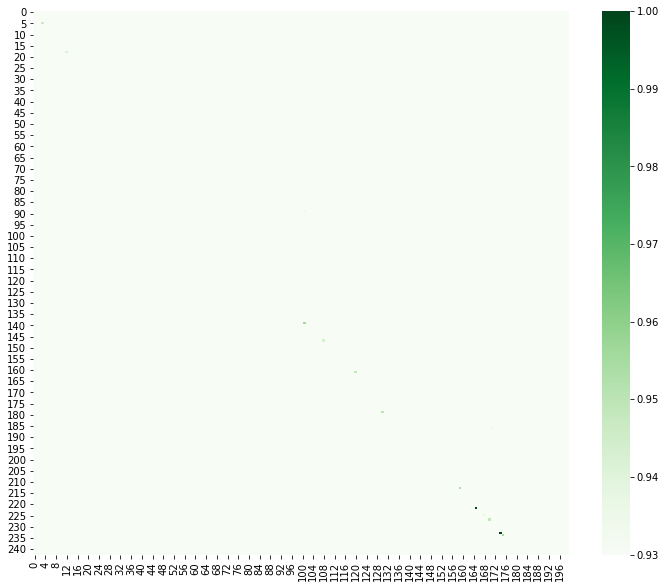


Pairs found: 15 


Total pairs found: 15 

--------------------------------------
Первый был не кто иной, как Михаил Александрович Берлиоз, председатель правления одной из крупнейших московских литературных ассоциаций, сокращенно именуемой МАССОЛИТ, и редактор толстого художественного журнала, а молодой спутник его — поэт Иван Николаевич Понырев, пишущий под псевдонимом Бездомный.

Первым был не кто иной, как Берлиоз Михаил Александрович, он был председателем Совета Мо Вэньляня нескольких крупных профсоюзов литературных и художественных деятелей в Москве. Молодой человек - поэт Понелев Иван Николаевич, который часто публиковал произведения под псевдонимом бездомных.

头一位不是别人，正是柏辽兹米哈伊尔亚历山大罗维奇，他是莫斯科几个主要的文艺工作者联合会之莫文联的理事会主席，同时兼任某大型文学刊物的主编，他身旁的年轻人则是常以无家汉的笔名发表作品的诗人波内列夫伊万尼古拉耶维奇。

Речь эта, как впоследствии узнали, шла об Иисусе Христе.

Позже мы узнали, что это был разговор о Христе Иисусе.

我们后来才知道，那是一场有关基督耶稣的谈话。

Ведь согласитесь, что в области разума никакого доказательства существования 

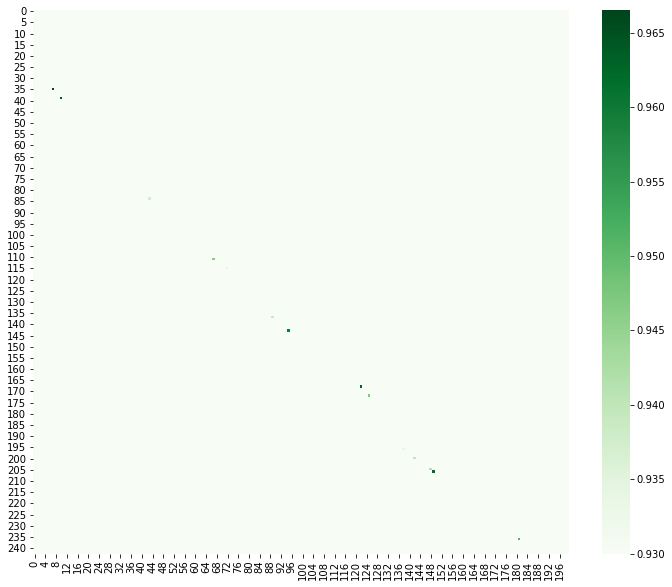


Pairs found: 14 


Total pairs found: 29 

--------------------------------------
— Да, консультантом.

Да, как консультант.

是的，担任顾问。

— Переспросил профессор и вдруг задумался.

Профессор задал вопрос и вдруг задумался.

教授反问了一句，忽然沉思起来。

— Он отказался дать заключение по делу и смертный приговор Синедриона направил на ваше утверждение, — объяснил секретарь.

Он отказался вынести решение по этому делу и отправил смертный приговор, вынесенный местным пленарным советом для вашего заказа.

他对此案拒不裁断，把地方全公会作出的死刑判决送过来请您定夺。

Но он знал, что и это ему не поможет.

Но он знал, что это тоже не помогло.

但他知道，这也无济于事。

Других слов не говорить.

Другие слова не допускаются.

不许用别的字眼儿。

— Я точно не знаю, — живо ответил арестованный, — я не помню моих родителей.

Я сам не уверен, арестованный быстро ответил, я не помню, кем были мои родители.

我自己也说不准，被捕者连忙回答，我不记得父母是谁。

Я один в мире.

Один в мире.

孤身一人在世。

Но он вырвал его у меня из рук и убежал.

Но он взял бумагу из моей руки и убежал.

可他从我手里

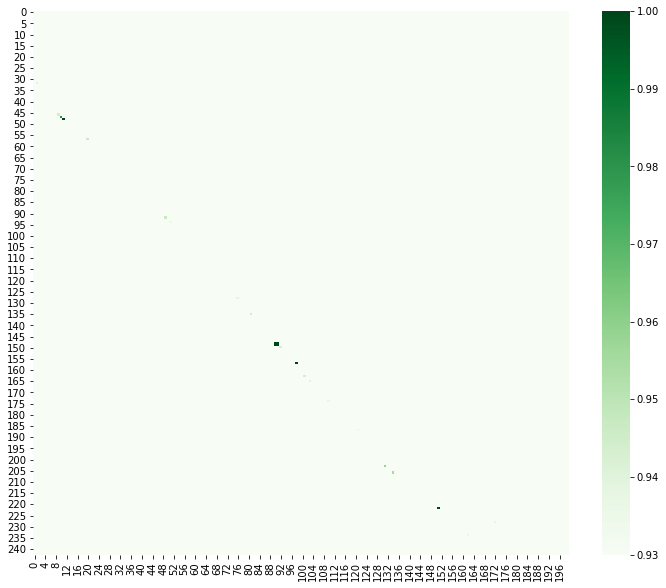


Pairs found: 24 


Total pairs found: 53 

--------------------------------------
— Этих добрых людей я не знаю, — ответил арестант.

Я не знаю этих добрых людей.

我不认识这些善人。

— Нет, я своим умом дошел до этого.

Нет, я сам это понял.

不，我是自己悟出来的。

— И ты проповедуешь это?

Вы проповедуете это?

那你就在宣讲它？

— Да.

Да.

是的。

Это было в бою при Идиставизо, в долине Дев.

Это было в битве дочери Игуэставеццо Долина.

这是在伊吉斯塔维佐的女儿谷战役中的事。

Или... не... говорил?

... Или не ... сказал?

……还是，没有……说过？

Молчание на балконе некоторое время нарушала только песня воды в фонтане.

Терраса стала очень тихой, нарушая тихий, только музыкальный фонтан звук.

凉台上变得十分宁静，打破这宁静的唯有音乐般的喷泉声。

Итак, Марк Крысобой, холодный и убежденный палач, люди, которые, как я вижу, — прокуратор указал на изуродованное лицо Иешуа, — тебя били за твои проповеди, разбойники Дисмас и Гестас, убившие со своими присными четырех солдат, и, наконец, грязный предатель Иуда — все они добрые люди?

Короче говоря, вы имеете в виду жесто

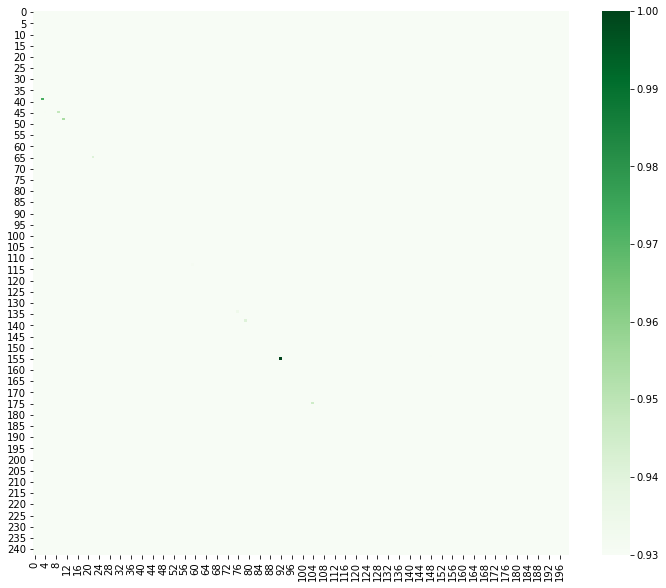


Pairs found: 12 


Total pairs found: 65 

--------------------------------------
Вспомни мое слово, первосвященник.

Запомни мои слова, первосвященник!

记住我的话吧，大祭司！

Увидишь ты не одну когорту в Ершалаиме, нет!

Нет, ты не веришь в это!

不，你也不相信！

Ты хотел его выпустить затем, чтобы он смутил народ, над верою надругался и подвел народ под римские мечи!

Вы хотели освободить его, потому что ожидали, что он подстрекает людей богохульствовать против религии и загонять массы под меч римских властей!

你本想释放他，因为你指望他煽动百姓亵渎宗教，从而把大众驱赶到罗马当局的刀剑之下！

Каифа вежливо поклонился, приложив руку к сердцу, и остался в саду, а Пилат вернулся на балкон.

Каиафа положил правую руку ему на грудь, вежливо поклонился и остался в саду.

该亚法把右手往胸前一捂，客气地躬身施礼，留在花园里。

"Все? — беззвучно шепнул себе Пилат, — все.

Пилат тайно задал себе все слова?

彼拉多暗暗问自己全讲了吗？

Вбросив меч в ножны, командир ударил плетью лошадь по шее, выровнял ее и поскакал в переулок, переходя в галоп.

Командир убрал меч в ножны и шлепнул лошад

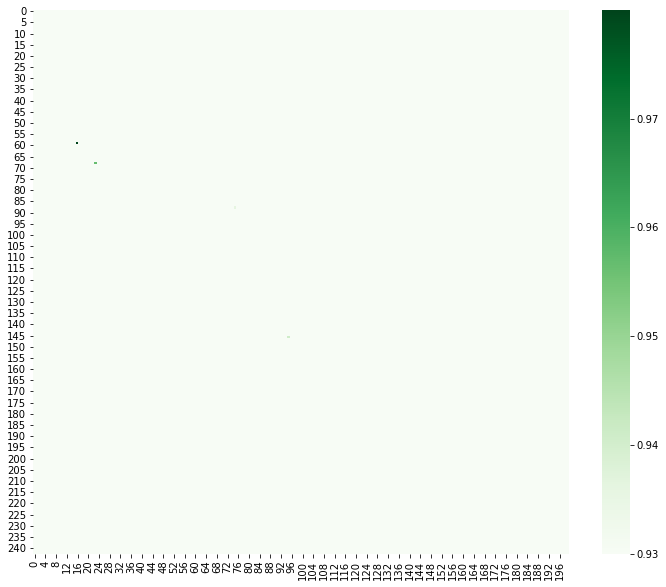


Pairs found: 4 


Total pairs found: 69 

--------------------------------------
Вы — убийца и шпион!

Вы убийца, шпион!

你是杀人凶手，特务！

Вы обязаны это сделать!

Вы обязаны помочь мне!

您有义务帮助我！

В ней никого не оказалось, и на плите в полумраке стояло безмолвно около десятка потухших примусов.

Здесь никого не было, и в тусклом свете он увидел десятки необожженных керосиновых печей, аккуратно расположенных под очагом.

这里一个人也没有，昏暗中他看到炉台下整齐地放着十来个没点火的煤油炉。

--------------------------------------
batch: 6 [ 1000 - 1200 ] Calculating vectors...
Calculating similarity matrix...


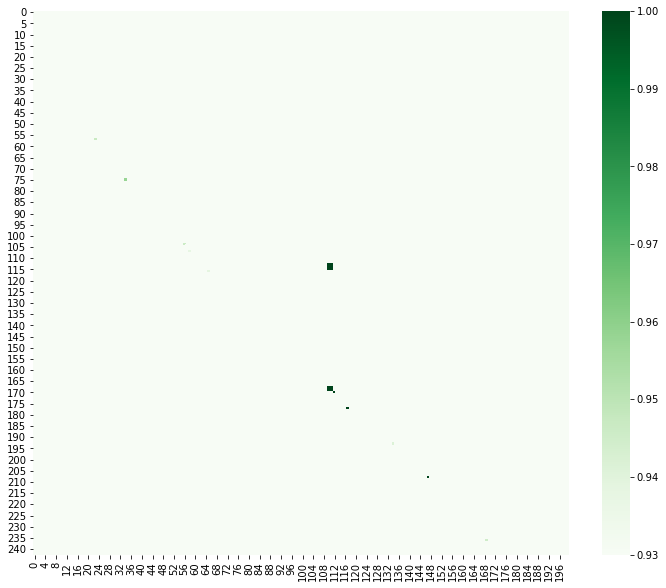


Pairs found: 20 


Total pairs found: 89 

--------------------------------------
Бескудников, искусственно зевнув, вышел из комнаты.

Бескудников сознательно зевнул и вышел из комнаты.

别斯库德尼科夫故意打了个哈欠，起身走出房间。

Возле обезглавленного стояли: профессор судебной медицины, патологоанатом и его прозектор, представители следствия и вызванный по телефону от больной жены заместитель Михаила Александровича Берлиоза по МАССОЛИТу — литератор Желдыбин.

Рядом с обезглавленным телом стояли анатом-патолог, профессор судебной медицины, его помощник, эксперт по вскрытию, представители следственного агентства, а также заместитель писателя Берлиоза Гердбин из «Мовенляна». Следователь позвонил по телефону от своей больной жены.

站在无头尸体旁边的是法医学教授病理解剖学家和他的助手尸体解剖专家及侦查机关的代表，还有柏辽兹在莫文联的副手文学家热尔德宾，他是刚从医院被侦查人员用电话从他患病的妻子身边叫来的。

Но нет, нет!

Ах, нет, нет!

啊，不对，不对！

Нет ничего, и ничего и не было!

Короче, ничего, ничего не произошло!

总之，什么都没有，什么都没有发生过！

— Что?

что?

什么？

Что?

что?

什么？

— Что?

что?

什么？

Что?

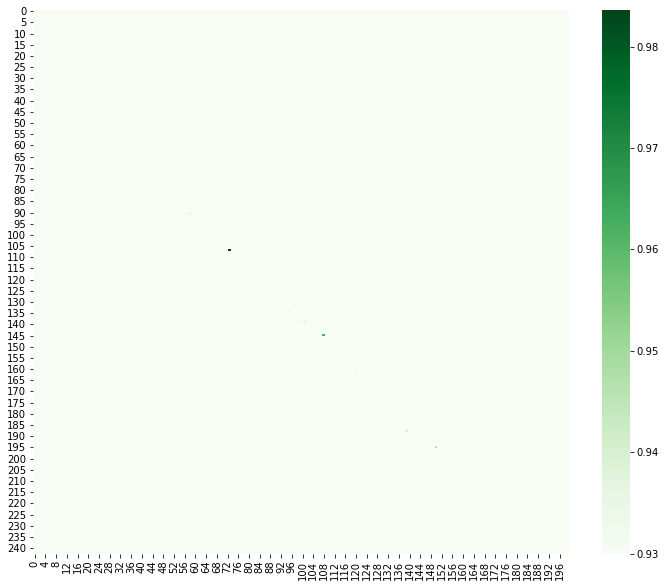


Pairs found: 8 


Total pairs found: 97 

--------------------------------------
— Какого консультанта?

Какой консультант поймать?

抓什么顾问？

— А кто—нибудь, кроме вас, видел этого консультанта?

Кто-нибудь кроме вас видел этого консультанта?

除了您之外，还有别人看见过这个顾问没有？

Я извиняюсь, где телефон?

Извините, где телефон?

对不起，电话在哪儿？

— Член профсоюза?

Вы член профсоюза?

是工会会员吗？

Как ваш адрес? — шепотом спросил Бездомный у доктора, прикрывая трубку ладонью, — а потом опять закричал в трубку: — Вы слушаете?

Бездомный закрыл микрофон рукой и прошептал доктору, а затем крикнул в микрофон, ты меня слушаешь?

无家汉用手捂住话筒小声问医生，然后又对着话筒大声说，您在听我说吗？

Он хрипел, пытался кусаться, кричал: — Так вот вы какие стеклышки у себя завели!..

Он хрипел и задыхался, пытался укусить зубами и продолжал кричать: «Вы надеваете этот стакан!

他呼哧呼哧喘着粗气，企图用牙咬人，不住地喊叫啊，你们装上了这种玻璃！

Светало, и свет еще не погашенных на шоссе фонарей был уже не нужен и неприятен.

Небо уже было освещено, а уличные фонари на шоссе не погасли

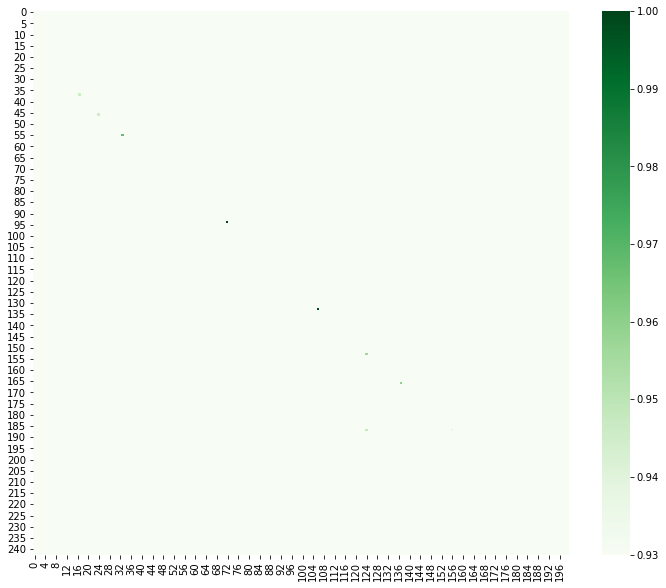


Pairs found: 11 


Total pairs found: 108 

--------------------------------------
В полутьме что—то тускло отсвечивало.

Что-то в темноте отражало тусклый свет.

昏黑中有件什么东西反射出一片灰暗的光。

Степа наконец узнал трюмо и понял, что он лежит навзничь у себя на кровати, то есть на бывшей ювелиршиной кровати, в спальне.

Он понял, что сейчас находится в спальне, лежа на спине, которая была кроватью бывшего ювелира.

他这才明白自己现在是在卧室，仰面躺在自己的也就是从前的珠宝商遗编的床上。

И вот два года тому назад начались в квартире необъяснимые происшествия: из этой квартиры люди начали бесследно исчезать.

Ровно два года назад люди в этом доме казались необъяснимыми один за другим, и жители начали исчезать один за другим.

恰恰是从两年前开始，这套房子里便接二连三地出现叫人无法解释的事住户开始一个个地失踪。

Однажды в выходной день явился в квартиру милиционер, вызвал в переднюю второго жильца фамилия которого утратилась и сказал, что того просят на минутку зайти в отделение милиции в чем—то расписаться.

Однажды это был выходной день: полицейский вошел в дом и позвонил 

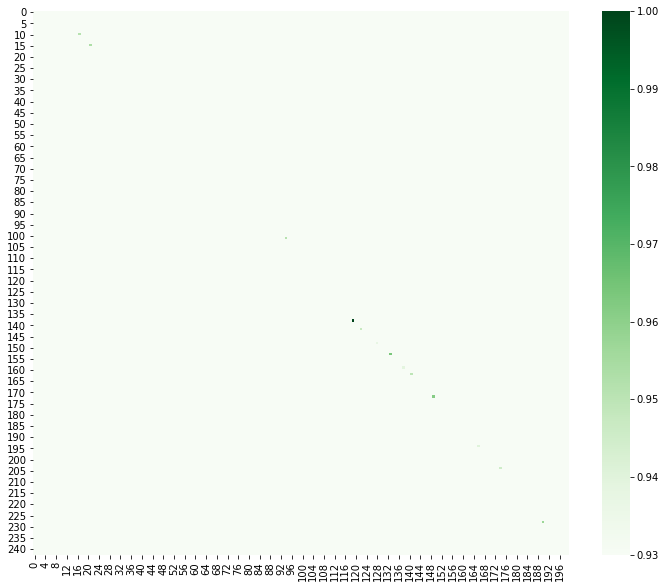


Pairs found: 14 


Total pairs found: 122 

--------------------------------------
На молу стоял какой—то человек, курил, плевал в море.

Человек стоял на волнорезе, время от времени куря и плюя в море.

防波堤上站着一个男人，正在抽烟，还不时地往海里吐唾沫。

— Я не пьян, — хрипло ответил Степа, — я болен, со мной что—то случилось, я болен...

Я не пьян, - хрипло сказал Скопа, - я болен, у меня что-то есть, я болен ... Где я?

我不是醉鬼，斯乔帕用沙哑的声音说，我是得了病，我出了点事，得了病……我这是在哪儿啊？

У нас каждый день интуристы бывают.

Иностранные туристы принимаются здесь каждый день.

这里每天接待外国旅游者。

Вся свита оказывала ему знаки внимания и уважения, и вход его получился поэтому очень торжественным.

Все сотрудники уважали его, поэтому его прибытие было очень торжественным.

全体人员都对他恭而敬之，因此，他的到来显得十分庄严。

— Пилата?

Пилат?

彼拉多？

— Ага, — сказал Стравинский, — а этот Берлиоз погиб под трамваем?

О, Стравинский сказал, ты имел в виду, что Берлиоз убил трамвай?

噢，斯特拉文斯基说，您是说柏辽兹让有轨电车轧死了？

Но эффекта не последовало, и Стравинский очень просто зад

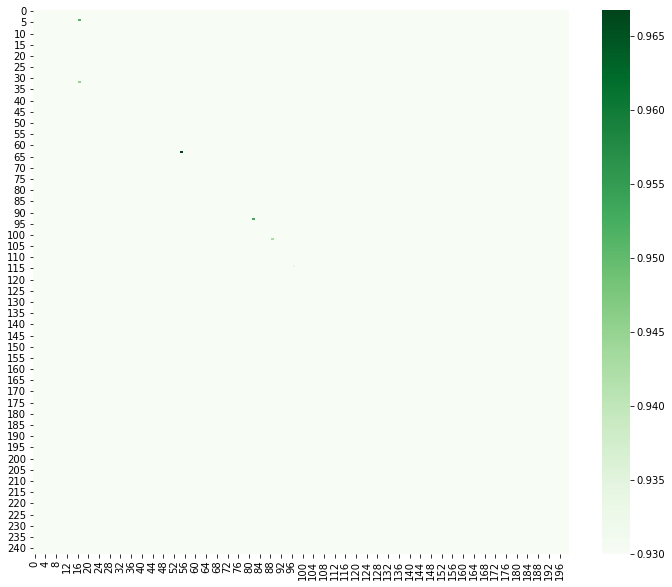


Pairs found: 6 


Total pairs found: 128 

--------------------------------------
— Ну хорошо.

это хорошо.

好。

— Ну хорошо.

Выглядит хорошо!

看，好极了！

Никто не отозвался.

Никто не ответил.

没有人回答。

Вы что здесь делаете?

Что ты здесь делаешь?

你在这儿干什么？

Иностранный артист господин Воланд был любезно приглашен директором Варьете Степаном Богдановичем Лиходеевым провести время своих гастролей, примерно недельку, у него в квартире, о чем он еще вчера написал Никанору Ивановичу, с просьбой прописать иностранца временно, покуда сам Лиходеев съездит в Ялту.

Переводчик с удовольствием объяснил, что иностранный актер г-н Волланд принял любезное приглашение руководителя Театра Валлета Шепамбодовича Лихотеева и согласился жить в его доме во время недельного тура Вчера Лихотеев обратился к Никанору Ивановичу с просьбой предоставить временный счет иностранным гостям, в течение которого сам Лихотеев собирался в Ялту.

翻译欣然作了解释外国演员沃兰德先生接受了瓦列特剧院经理斯杰潘博格达诺维奇利霍捷耶夫的盛情邀请，同意在为期一周的巡回演出期间住在他家里这件事利霍捷耶夫昨天

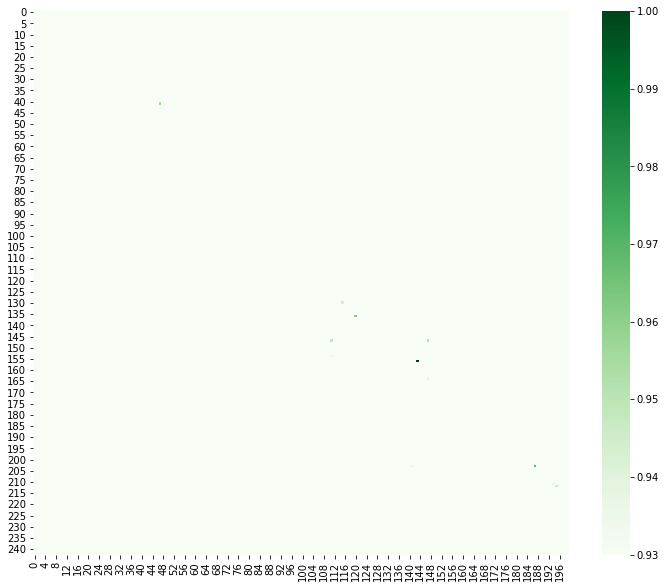


Pairs found: 13 


Total pairs found: 141 

--------------------------------------
И маг этот смылся, и никто его не видел, кроме самого Степы.

Теперь маг поскользнулся, и никто, кроме самого Скопа, не видел этого человека.

现在魔术家溜了，除斯乔帕本人外，谁也没见过这个人。

Да если бы и улетел вчера вечером, к полудню сегодняшнего дня не долетел бы.

Даже если бы я летел самолетом прошлой ночью, я не смогу вылететь в Ялту сегодня в полдень!

就算是昨天晚上乘飞机走的，今天中午也飞不到雅尔塔呀！

До Севастополя по железной дороге около полутора тысяч километров.

Протяженность железной дороги до Севастополя составляет около 1500 километров.

到塞瓦斯托波尔的铁路里程大约一千五百公里。

Ну, нет, извините, этого не бывает!...

Привет, бойцы не имеют ничего общего с этим вопросом.

嗨，战斗机同这事根本没有关系。

Гипноз?

Гипноз?

催眠术？

Этого не может быть, а значит, его нет в Ялте.

Скопа не может быть в Ялте!

斯乔帕不可能在雅尔塔！

Этого не может быть, а значит, его нет в Ялте.

Извините, разве Шепамбодовича Лихотеева сейчас нет дома?

请问，斯杰潘博格达诺维奇利霍捷耶夫现在不在家吗？

— Простите, что, С

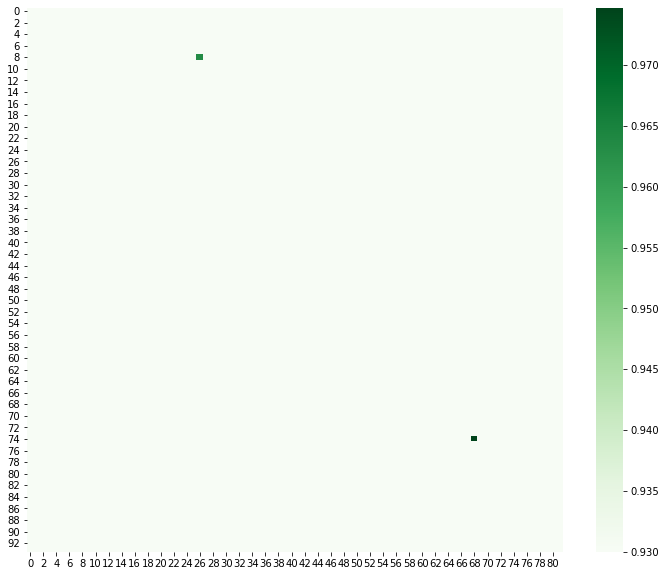


Pairs found: 2 


Total pairs found: 143 

--------------------------------------
— Он с ума сошел... — слабо сказал Варенуха.

Он сошел с ума ... Валенуха сказал слабо.

他疯了……瓦列奴哈有气无力地说。

Предупреждали, я тебя спрашиваю?

Я спросил тебя, ты предупреждал?

我问你，警告过没有？

Done. Total pairs found: 143


In [99]:
#0.87 - 104
file_ru = r"D:\ml\c\raw\chekhov_futlar_ru.txt"
file_zh = r"D:\ml\c\raw\chekhov_futlar_zh.txt"

#
file_ru = r"D:\ml\c\raw\stal_ru.txt"
file_zh = r"D:\ml\c\raw\stal_zh.txt"

# #0.84 - 22
# file_ru = r"D:\ml\c\raw\lu_xun_ben_ye_ru.txt"
# file_zh = r"D:\ml\c\raw\lu_xun_ben_ye_zh.txt"

# file_ru = r"D:\ml\c\raw\idiot_ru.txt"
# file_zh = r"D:\ml\c\raw\idiot_zh.txt"

file_ru = r"D:\ml\c\raw\master_ru.txt"
file_zh = r"D:\ml\c\raw\master_zh.txt"

v1, v2 = align_texts(file_ru, file_zh, threshold=0.93, batch_size=200, window=50, n_gram=1, \
                     n_gram_sent_max_words=12, l_diff=0.6, debug=False)

In [64]:
#v1, v2 = align_texts(file_ru, file_zh, 0.85, v1, v2)